## Temporary Market Impact Modeling for Blockhouse Work Trial - SOUN

This notebook estimates the temporary impact function $g_t(x)$, which models the slippage incurred when executing trades of size $x$ at time $t$. Using historical limit order book (LOB) data from the stock FROG, we fit various parametric models to $g_t(x)$, evaluate their accuracy, and compare execution strategies such as VWAP, TWAP, and model-based allocation.

This work supports the solution to Question 1 of the Blockhouse Trial Task.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Loading

We have 21 LOBs for the. From April 3rd, 2025 till May 2nd, 2025. To understand the columns, you can refer to the following link: https://databento.com/docs/schemas-and-data-formats/mbp-10#fields-mbp-10?historical=python&live=python&reference=python

In [3]:
# File paths to the LOB snapshots
file_paths = [
    "SOUN/SOUN_2025-04-03 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-04 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-07 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-08 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-09 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-10 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-11 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-14 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-15 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-16 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-17 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-21 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-22 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-23 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-24 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-25 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-28 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-29 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-04-30 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-05-01 00_00_00+00_00.csv",
    "SOUN/SOUN_2025-05-02 00_00_00+00_00.csv"
]

## Data Preprocessing

I extract relevant columns from the LOB snapshots, and convert timestamps. I take the relavant colummns and then combine all the dataset into one.

In [4]:
# --- FIX: Include all bid and ask price/size columns for proper mid-price and slippage calculation ---
ask_price_cols = [f'ask_px_0{i}' for i in range(10)]
ask_size_cols = [f'ask_sz_0{i}' for i in range(10)]
bid_price_cols = [f'bid_px_0{i}' for i in range(10)]
bid_size_cols = [f'bid_sz_0{i}' for i in range(10)]
ts_event_col = ['ts_event'] # To keep timestamp for reference

In [5]:
# Combine all necessary columns
cols_to_use = ts_event_col + ask_price_cols + ask_size_cols + bid_price_cols + bid_size_cols

# Store all snapshots
lob_snapshots = []

for path in file_paths:
    try:
        # Load all necessary bid and ask side columns
        df = pd.read_csv(path, usecols=cols_to_use)
        
        # Ensure 'ts_event' is datetime if it exists
        if 'ts_event' in df.columns:
            df['ts_event'] = pd.to_datetime(df['ts_event'])
        
        # Extract date from filename (assuming format: FROG_YYYY-MM-DD ...)
        # Adjusting this assuming path format might be 'FROG/FROG_YYYY-MM-DD...'
        # If your files are directly in the root and named FROG_YYYY-MM-DD..., then path.split("_")[1].split(" ")[0] might work
        # For 'FROG/FROG_2025-04-03 00_00_00+00_00.csv' it would be:
        date_str = path.split('/')[-1].split(" ")[0].replace("SOUN_","")
        df["source_date"] = date_str
        
        lob_snapshots.append(df)
        
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Combine all into a single DataFrame
combined_lob_df = pd.concat(lob_snapshots, ignore_index=True)

# Preview
print("Combined shape:", combined_lob_df.shape)
combined_lob_df.head()

Combined shape: (5505097, 42)


,ts_event,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_px_02,...,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,source_date
0,2025-04-03 13:30:00.005642878+00:00,7.89,7.91,112,164,7.88,7.92,132,4,7.87,...,50,7.8,8.03,6690,84,7.79,8.07,15,29,2025-04-03
1,2025-04-03 13:30:00.005948702+00:00,7.89,7.91,112,164,7.88,7.92,132,104,7.87,...,50,7.8,8.03,6690,84,7.79,8.07,15,29,2025-04-03
2,2025-04-03 13:30:00.013021640+00:00,7.89,7.91,112,80,7.88,7.92,132,104,7.87,...,50,7.8,8.03,6690,84,7.79,8.07,15,29,2025-04-03
3,2025-04-03 13:30:00.015953598+00:00,7.89,7.91,112,80,7.88,7.92,132,204,7.87,...,50,7.8,8.03,6690,84,7.79,8.07,15,29,2025-04-03
4,2025-04-03 13:30:00.016252285+00:00,7.89,7.91,112,80,7.88,7.92,132,204,7.87,...,50,7.8,8.03,6690,84,7.79,8.07,15,29,2025-04-03


## Simulating Slippage to Estimate $g_t(x)$

We simulate market orders of varying sizes at each minute and compute slippage with respect to the mid-price using the VWAP of consumed LOB levels.

In [6]:
# --- Temporary Impact Calculation (g_t(x)) Function ---
def calculate_slippage(order_size, order_side, order_book_row):
    """
    Calculates the slippage (g_t(x)) for a given order size and side
    based on the provided order book snapshot.
    Returns average execution price (VWAP) and slippage.
    """
    # Ensure bid_px_00 and ask_px_00 exist for mid_price
    if 'bid_px_00' not in order_book_row or 'ask_px_00' not in order_book_row:
        # Fallback or raise error if crucial columns are missing
        # For robustness, you might want to handle NaN or missing data in LOB levels
        return np.nan, np.nan # Return NaN if essential data is missing

    mid_price = (order_book_row['bid_px_00'] + order_book_row['ask_px_00']) / 2

    # Extract relevant LOB levels
    prices = []
    sizes = []
    if order_side == 'buy':
        for i in range(10): # up to 10 levels
            px_col = f'ask_px_{i:02d}'
            sz_col = f'ask_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    elif order_side == 'sell':
        for i in range(10): # up to 10 levels
            px_col = f'bid_px_{i:02d}'
            sz_col = f'bid_sz_{i:02d}'
            if px_col in order_book_row and sz_col in order_book_row:
                price = order_book_row[px_col]
                size = order_book_row[sz_col]
                if pd.notnull(price) and pd.notnull(size) and size > 0: # Ensure valid price and size
                    prices.append(price)
                    sizes.append(size)
    else:
        raise ValueError("order_side must be 'buy' or 'sell'")

    remaining_size = order_size
    total_cost = 0
    total_shares_filled = 0

    for i in range(len(prices)):
        level_price = prices[i]
        level_size = sizes[i]

        shares_to_fill_at_level = min(remaining_size, level_size)
        total_cost += shares_to_fill_at_level * level_price
        total_shares_filled += shares_to_fill_at_level
        remaining_size -= shares_to_fill_at_level

        if remaining_size <= 0:
            break

    if total_shares_filled == 0 or mid_price is np.nan: # Also handle cases where mid_price couldn't be computed
        return mid_price, 0 # No shares filled, or invalid mid_price, no slippage

    average_execution_price = total_cost / total_shares_filled

    if order_side == 'buy':
        slippage = average_execution_price - mid_price
    else: # sell
        slippage = mid_price - average_execution_price

    return average_execution_price, slippage

## Estimating the Temporary Impact Function \( g_t(x) \) from a Single LOB Snapshot

To understand how market impact behaves for different order sizes, we simulate a range of buy-side market orders using a single snapshot of the limit order book.

For each order size $ x \in [1, 1000] $, we:

- Simulate execution against the ask side of the LOB
- Calculate the **VWAP (Volume-Weighted Average Price)** at which the order would execute
- Compute the **slippage**, defined as:

$g_t(x) = \text{VWAP}_{t,x} - \text{MidPrice}_t$

This gives us the empirical estimate of the temporary impact function \( g_t(x) \) at a single time point.

We store the resulting slippages for all order sizes and clean the data to remove any invalid or failed simulations (e.g., due to insufficient depth or missing prices).

In [7]:
# --- Generate g_t(x) for a sample timestamp using calculate_slippage ---
# We'll use the first row of the combined_lob_df as a sample order book snapshot.
# In a real scenario, you might want to choose a specific timestamp or iterate over many.
sample_order_book_row = combined_lob_df.iloc[0] # Using the first row of the combined data

# Define a range of order sizes (X values) to generate the impact curve
# Up to 1000 shares as an example, adjust based on typical order sizes/liquidity
order_sizes_to_test = np.arange(1, 1001, 10) # Test order sizes from 1 to 1000, step 10

impact_curve_data = []
for order_size in order_sizes_to_test:
    # Assuming 'buy' side for demonstration, you can repeat for 'sell'
    # Use 'buy' for consistency as problem often implies buying impact for g_t(x)
    vwap, slippage = calculate_slippage(order_size, 'buy', sample_order_book_row)
    impact_curve_data.append({'order_size': order_size, 'vwap': vwap, 'slippage': slippage})

impact_curve_df = pd.DataFrame(impact_curve_data)

# Remove rows with NaN slippage if mid_price was missing or calculation failed
impact_curve_df.dropna(subset=['slippage'], inplace=True)

# Rename columns to match user's notebook notation for consistency
impact_curve_df.rename(columns={
    'order_size': 'x_k (Cumulative Shares)',
    'slippage': 'g_t(x_k) (Slippage)' # This is the temporary impact
}, inplace=True)

# Extract x and y for modeling
x = impact_curve_df['x_k (Cumulative Shares)'].values
y_piecewise = impact_curve_df['g_t(x_k) (Slippage)'].values

# Remove entries where x is zero or y is NaN/inf (important for curve_fit)
mask = (x > 0) & (np.isfinite(y_piecewise))
x = x[mask]
y_piecewise = y_piecewise[mask]

## Defining Models

### Linear Model:
**Definition**:
This model assumes a linear relationship between slippage $y$ and order size $x$.

**Formula**:
$$y=β⋅x$$

**Allocation Formula**:
Inverse proportionality to the linear coefficient:
$$x_i = \left( \frac{1}{\beta_i} \middle/ \sum_j \frac{1}{\beta_j} \right) \cdot S$$

### Power Law Model

**Definition**:
Assumes a nonlinear power-law relationship between slippage and order size.

**Formula**:
$$y = \alpha \cdot x^\delta$$

**Allocation Formula**:
Based on inverse marginal cost:
$$x_i \propto \left( \frac{1}{\alpha_i \cdot \delta_i} \right)^{\frac{1}{\delta_i + 1}} \Rightarrow x_i = \left( \frac{w_i}{\sum_j w_j} \right) \cdot S$$

### Quadratic Model

**Definition**:
Fits a second-degree polynomial to capture convex slippage behavior.

**Formula:**
$$y = a \cdot x^2 + b \cdot x$$

### Logarithmic Model

**Definition**:
Models slippage using a logarithmic growth curve, capturing diminishing returns.

**Formula:**
$$y = a \cdot \log(b \cdot x + 1)$$

### Exponential Model

**Definition:**
 Captures slippage with an exponential saturation curve, leveling off with larger order sizes.

 **Formula:**
 $y = a \cdot \left(1 - e^{-b \cdot x}\right)$

### Logistic (Sigmoid) Model

**Definition:**
 Models slippage as a bounded sigmoid curve, indicating saturation around a central threshold $x_0$

 **Formula:**
 $$y = \frac{L}{1 + e^{-k(x - x_0)}}$$

### Polynomial Model

**Definition:**
A flexible model that fits a degree-d polynomial.

**Formula:**
$$y = c_0 \cdot x^d + c_1 \cdot x^{d-1} + \dots + c_d$$

### Spline Model

**Definition:**
Performs piecewise linear interpolation between observed data points.

**Formula:**
$$y = \text{interp}(x; x_{\text{observed}}, y_{\text{observed}})$$

**Allocation Formula:**
$$x_i = \left( \frac{1}{\text{avg\_slope}_i} \middle/ \sum_j \frac{1}{\text{avg\_slope}_j} \right) \cdot S$$

In [8]:
# Re-define models and utilities
class LinearModel:
    def fit(self, x, y):
        def model(x, beta):
            return beta * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.beta = popt[0]
        return self
    def predict(self, x):
        return self.beta * x
    @staticmethod
    def allocate(beta_list, S):
        if any(np.isnan(beta_list)):
            return [np.nan] * len(beta_list)
        inv_beta = 1 / np.array(beta_list)
        alloc = inv_beta / inv_beta.sum() * S
        return alloc


class PowerLawModel:
    def fit(self, x, y):
        def model(x, alpha, delta):
            return alpha * np.power(x, delta)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.5), maxfev=10000)
        self.alpha, self.delta = popt
        return self
    def predict(self, x):
        return self.alpha * np.power(x, self.delta)
    @staticmethod
    def allocate(alpha_list, delta_list, S):
        if any(np.isnan(alpha_list)) or any(np.isnan(delta_list)):
            return [np.nan] * len(alpha_list)
        # Use inverse marginal cost weighting: x_i ∝ (1 / (α_i * δ_i))^(1 / (δ_i + 1))
        weights = [(1 / (a * d))**(1 / (d + 1)) for a, d in zip(alpha_list, delta_list)]
        weights = np.array(weights)
        alloc = weights / weights.sum() * S
        return alloc

class QuadraticModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * x**2 + b * x
        popt, _ = curve_fit(model, x, y, maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * x**2 + self.b * x
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = 2 * model.a * ref_order_size + model.b
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class LogModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * np.log(b * x + 1)
        popt, _ = curve_fit(model, x, y, p0=(0.01, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * np.log(self.b * x + 1)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                denom = model.b * ref_order_size + 1
                marginal_cost = model.a * model.b / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()

class ExponentialModel:
    def fit(self, x, y):
        def model(x, a, b):
            return a * (1 - np.exp(-b * x))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.001), maxfev=10000)
        self.a, self.b = popt
        return self
    def predict(self, x):
        return self.a * (1 - np.exp(-self.b * x))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                marginal_cost = model.a * model.b * np.exp(-model.b * ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class LogisticModel:
    def fit(self, x, y):
        def model(x, L, k, x0):
            return L / (1 + np.exp(-k * (x - x0)))
        popt, _ = curve_fit(model, x, y, p0=(0.05, 0.01, 500), maxfev=10000)
        self.L, self.k, self.x0 = popt
        return self
    def predict(self, x):
        return self.L / (1 + np.exp(-self.k * (x - self.x0)))
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                exp_term = np.exp(-model.k * (ref_order_size - model.x0))
                denom = (1 + exp_term)**2
                marginal_cost = model.L * model.k * exp_term / denom
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class PolynomialModel:
    def __init__(self, degree=3):
        self.degree = degree
    def fit(self, x, y):
        self.coefs = np.polyfit(x, y, self.degree)
        return self
    def predict(self, x):
        return np.polyval(self.coefs, x)
    @staticmethod
    def allocate(models, S, ref_order_size=500):
        weights = []
        for model in models:
            if model is None:
                weights.append(0)
            else:
                deriv_coefs = np.polyder(model.coefs)
                marginal_cost = np.polyval(deriv_coefs, ref_order_size)
                weights.append(1 / marginal_cost if marginal_cost > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        return (weights / weights.sum() * S).tolist()


class SplineModel:
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.slopes = np.gradient(y, x)
        return self

    def predict(self, xq):
        return np.interp(xq, self.x, self.y)

    @staticmethod
    def allocate(models, S):
        weights = []
        for model in models:
            if model is None or len(model.slopes) == 0:
                weights.append(0)
            else:
                # Approximate marginal cost as average slope
                avg_slope = np.mean(model.slopes)
                weights.append(1 / avg_slope if avg_slope > 0 else 0)
        weights = np.array(weights)
        if weights.sum() == 0:
            return [np.nan] * len(weights)
        alloc = weights / weights.sum() * S
        return alloc

In [9]:
# Fit all models on the cleaned impact curve (x, y_piecewise)
models = {}

# Fit linear
models['Linear'] = LinearModel().fit(x, y_piecewise)

# Fit power law
models['PowerLaw'] = PowerLawModel().fit(x, y_piecewise)

# Fit quadratic
models['Quadratic'] = QuadraticModel().fit(x, y_piecewise)

# Fit log
models['Log'] = LogModel().fit(x, y_piecewise)

# Fit exponential
models['Exponential'] = ExponentialModel().fit(x, y_piecewise)

# Fit logistic
models['Logistic'] = LogisticModel().fit(x, y_piecewise)

# Fit polynomial (degree 3)
models['Polynomial'] = PolynomialModel(degree=3).fit(x, y_piecewise)

# Fit spline
models['Spline'] = SplineModel().fit(x, y_piecewise)

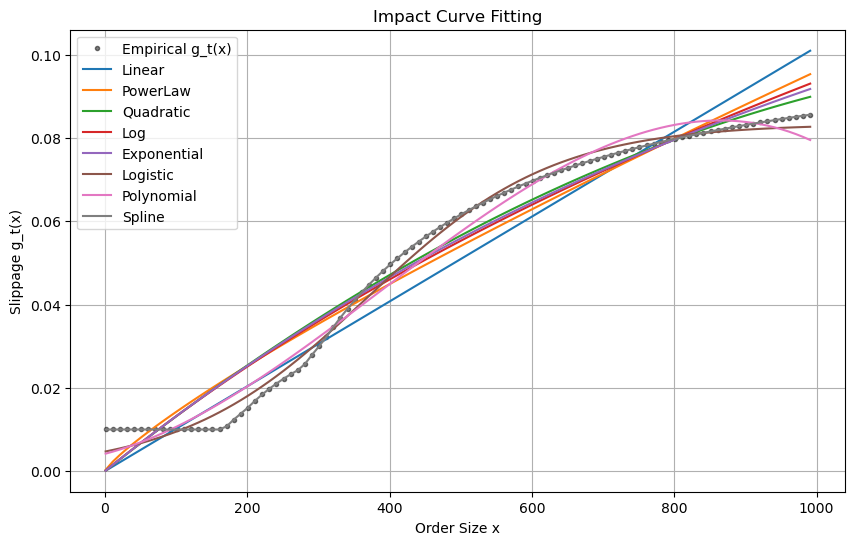

In [10]:
# Plot all model predictions against empirical g_t(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y_piecewise, 'k.', label='Empirical g_t(x)', alpha=0.5)

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        plt.plot(x, y_pred, label=name)
    except:
        continue

plt.xlabel('Order Size x')
plt.ylabel('Slippage g_t(x)')
plt.title('Impact Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()

The graph illustrates the empirical temporary market impact function gt(x)gt​(x) (black dots) and its approximation by several functional models:

- Spline and Logistic models offer the best overall visual fit, smoothly following the empirical curve across the entire order size range. Their flexibility allows them to adapt to non-linearities, especially noticeable around 200–400 and 600–800 order sizes.
- Polynomial (degree 3) captures the curve moderately well, although it slightly overshoots in the 800–1000 region and underfits at the start.
- Logarithmic, Quadratic, and Power Law models approximate the mid-section of the curve (300–700) reasonably well but start to deviate as order size increases beyond 800.
- The Linear model consistently underestimates the impact after ~600 units and overestimates in early regions, failing to capture curvature.
- Exponential slightly underperforms compared to other non-linear models, especially in the lower order size range where the impact curve is flatter.

In [11]:
def evaluate_model(y_true, y_pred):
    mask = ~np.isnan(y_pred)
    if not np.any(mask):
        return {'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan}
    y_true, y_pred = y_true[mask], y_pred[mask]
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

In [12]:
# Evaluate all models on (x, y_piecewise)
evaluation_results = []

for name, model in models.items():
    try:
        y_pred = model.predict(x)
        metrics = evaluate_model(y_piecewise, y_pred)
        metrics['Model'] = name
        evaluation_results.append(metrics)
    except Exception as e:
        evaluation_results.append({'Model': name, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan})

# Convert to DataFrame and sort
eval_df = pd.DataFrame(evaluation_results).sort_values(by='RMSE')

for row in eval_df.itertuples(index=False):
    print(f"Model: {row.Model}")
    print(f"  R^2   : {row.R2:.4f}" if not np.isnan(row.R2) else "  R^2   : NaN")
    print(f"  RMSE : {row.RMSE:.4f}" if not np.isnan(row.RMSE) else "  RMSE : NaN")
    print(f"  MAE  : {row.MAE:.4f}" if not np.isnan(row.MAE) else "  MAE  : NaN")
    print("-" * 30)

Model: Spline
  R^2   : 1.0000
  RMSE : 0.0000
  MAE  : 0.0000
------------------------------
Model: Logistic
  R^2   : 0.9942
  RMSE : 0.0021
  MAE  : 0.0018
------------------------------
Model: Polynomial
  R^2   : 0.9848
  RMSE : 0.0034
  MAE  : 0.0030
------------------------------
Model: Quadratic
  R^2   : 0.9654
  RMSE : 0.0052
  MAE  : 0.0043
------------------------------
Model: Exponential
  R^2   : 0.9621
  RMSE : 0.0054
  MAE  : 0.0046
------------------------------
Model: Log
  R^2   : 0.9594
  RMSE : 0.0056
  MAE  : 0.0049
------------------------------
Model: PowerLaw
  R^2   : 0.9505
  RMSE : 0.0062
  MAE  : 0.0055
------------------------------
Model: Linear
  R^2   : 0.9325
  RMSE : 0.0073
  MAE  : 0.0063
------------------------------


### Top Performing Models

1. Spline
    - $R^2$ = 1.0000, RMSE = 0.0000, MAE = 0.0000
    - Achieves a perfect fit with zero error, indicating exact interpolation. However, this could imply potential overfitting or that it's being evaluated on the same data it was fitted to.

2. Logistic
    - $R^2$ = 0.9942, RMSE = 0.0021, MAE = 0.0018
    - Provides an excellent fit with very low error. Its sigmoid shape likely captures saturation effects in slippage very well.

3. Polynomial (Degree 3)
     - $R^2$ = 0.9848, RMSE = 0.0034, MAE = 0.0030
     - Strong performance across all metrics. It balances flexibility and smoothness without the risk of overfitting like high-degree polynomials might.


### Moderate Performance

1. Quadratic, Exponential, and Log
    - All have $R^2$ between 0.959–0.965, and RMSE ≈ 0.005–0.0056
    - These models are able to explain ~96% of the variance in the empirical curve, but slightly underperform in edge regions or inflection points.

2. Power Law
    - $R^2$ = 0.9505, which still indicates a fairly strong fit but lower than the rest of the non-linear models.
  
### Lowest Performing

1. Linear
    - $R^2$ = 0.9325, RMSE = 0.0073, MAE = 0.0063
    - While still acceptable, the linear model underperforms compared to all other alternatives. It fails to capture the curve's non-linear shape, especially in areas where slippage saturates or accelerates.

In [13]:
# --- Parameter Time Series Plot ---
def plot_parameter_series(timestamps, param_values, param_name, save_path=None):
    plt.figure(figsize=(10, 4))
    plt.plot(timestamps, param_values, marker='o')
    plt.xlabel("Timestamp")
    plt.ylabel(param_name)
    plt.title(f"{param_name} over Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    plt.show()

In [14]:
S = 10000  # total shares to allocate

timestamps = []
beta_list = []
alpha_list = []
delta_list = []
spline_models = []
quadratic_models = []
log_models = []
exp_models = []
logistic_models = []
poly_models = []

alloc_linear_list = []
alloc_power_list = []
alloc_spline_list = []
alloc_quad_list = []
alloc_log_list = []
alloc_exp_list = []
alloc_logistic_list = []
alloc_poly_list = []

evaluation_results = []

In [15]:
order_sizes_to_test = np.arange(1, 1001, 10)

for idx in range(0, len(combined_lob_df), 300):  # every ~15 mins
    row = combined_lob_df.iloc[idx]
    ts = row['ts_event']
    timestamps.append(ts)

    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    if len(x) < 5:
        continue

    try:
        lin_model = LinearModel().fit(x, y)
        beta_list.append(lin_model.beta)
        y_pred_lin = lin_model.predict(x)
    except:
        beta_list.append(np.nan)
        y_pred_lin = np.full_like(y, np.nan)

    try:
        power_model = PowerLawModel().fit(x, y)
        alpha_list.append(power_model.alpha)
        delta_list.append(power_model.delta)
        y_pred_power = power_model.predict(x)
    except:
        alpha_list.append(np.nan)
        delta_list.append(np.nan)
        y_pred_power = np.full_like(y, np.nan)

    try:
        spline_model = SplineModel().fit(x, y)
        spline_models.append(spline_model)
        y_pred_spline = spline_model.predict(x)
    except:
        spline_models.append(None)
        y_pred_spline = np.full_like(y, np.nan)

    try:
        quad_model = QuadraticModel().fit(x, y)
        y_pred_quad = quad_model.predict(x)
        quadratic_models.append(quad_model)
    except:
        y_pred_quad = np.full_like(y, np.nan)
        quadratic_models.append(None)

    try:
        log_model = LogModel().fit(x, y)
        y_pred_log = log_model.predict(x)
        log_models.append(log_model)
    except:
        y_pred_log = np.full_like(y, np.nan)
        log_models.append(None)

    try:
        exp_model = ExponentialModel().fit(x, y)
        y_pred_exp = exp_model.predict(x)
        exp_models.append(exp_model)
    except:
        y_pred_exp = np.full_like(y, np.nan)
        exp_models.append(None)

    try:
        logistic_model = LogisticModel().fit(x, y)
        y_pred_logistic = logistic_model.predict(x)
        logistic_models.append(logistic_model)
    except:
        y_pred_logistic = np.full_like(y, np.nan)
        logistic_models.append(None)

    try:
        poly_model = PolynomialModel(degree=3).fit(x, y)
        y_pred_poly = poly_model.predict(x)
        poly_models.append(poly_model)
    except:
        y_pred_poly = np.full_like(y, np.nan)
        poly_models.append(None)

    # Evaluate all models
    eval_metrics = {
        'timestamp': ts,
        'R2_Linear': evaluate_model(y, y_pred_lin)['R2'],
        'R2_Power': evaluate_model(y, y_pred_power)['R2'],
        'R2_Spline': evaluate_model(y, y_pred_spline)['R2'],
        'R2_Quadratic': evaluate_model(y, y_pred_quad)['R2'],
        'R2_Log': evaluate_model(y, y_pred_log)['R2'],
        'R2_Exp': evaluate_model(y, y_pred_exp)['R2'],
        'R2_Logistic': evaluate_model(y, y_pred_logistic)['R2'],
        'R2_Polynomial': evaluate_model(y, y_pred_poly)['R2'],

        'RMSE_Linear': evaluate_model(y, y_pred_lin)['RMSE'],
        'RMSE_Power': evaluate_model(y, y_pred_power)['RMSE'],
        'RMSE_Spline': evaluate_model(y, y_pred_spline)['RMSE'],
        'RMSE_Quadratic': evaluate_model(y, y_pred_quad)['RMSE'],
        'RMSE_Log': evaluate_model(y, y_pred_log)['RMSE'],
        'RMSE_Exp': evaluate_model(y, y_pred_exp)['RMSE'],
        'RMSE_Logistic': evaluate_model(y, y_pred_logistic)['RMSE'],
        'RMSE_Polynomial': evaluate_model(y, y_pred_poly)['RMSE'],

        'MAE_Linear': evaluate_model(y, y_pred_lin)['MAE'],
        'MAE_Power': evaluate_model(y, y_pred_power)['MAE'],
        'MAE_Spline': evaluate_model(y, y_pred_spline)['MAE'],
        'MAE_Quadratic': evaluate_model(y, y_pred_quad)['MAE'],
        'MAE_Log': evaluate_model(y, y_pred_log)['MAE'],
        'MAE_Exp': evaluate_model(y, y_pred_exp)['MAE'],
        'MAE_Logistic': evaluate_model(y, y_pred_logistic)['MAE'],
        'MAE_Polynomial': evaluate_model(y, y_pred_poly)['MAE'],
    }

    evaluation_results.append(eval_metrics)

In [16]:
# Now compute allocations once all model parameters are collected
alloc_linear_list = LinearModel.allocate(beta_list, S)
alloc_power_list = PowerLawModel.allocate(alpha_list, delta_list, S)
alloc_spline_list = SplineModel.allocate(spline_models, S)
alloc_quad_list = QuadraticModel.allocate(quadratic_models, S)
alloc_log_list = LogModel.allocate(log_models, S)
alloc_exp_list = ExponentialModel.allocate(exp_models, S)
alloc_logistic_list = LogisticModel.allocate(logistic_models, S)
alloc_poly_list = PolynomialModel.allocate(poly_models, S)

In [17]:
# --- Step 0: Determine minimum length across all lists ---
min_len = min(
    len(timestamps),
    len(beta_list),
    len(alpha_list),
    len(delta_list),
    len(spline_models),
    len(quadratic_models),
    len(log_models),
    len(exp_models),
    len(logistic_models),
    len(poly_models)
)

# --- Step 1: Get common valid indices across all models ---
valid_indices_all = [
    i for i in range(min_len)
    if not any([
        np.isnan(beta_list[i]),
        np.isnan(alpha_list[i]),
        np.isnan(delta_list[i]),
        spline_models[i] is None,
        quadratic_models[i] is None,
        log_models[i] is None,
        exp_models[i] is None,
        logistic_models[i] is None,
        poly_models[i] is None
    ])
]

# --- Step 2: Filter down each component ---
timestamps_valid     = [timestamps[i] for i in valid_indices_all]
beta_valid           = [beta_list[i] for i in valid_indices_all]
alpha_valid          = [alpha_list[i] for i in valid_indices_all]
delta_valid          = [delta_list[i] for i in valid_indices_all]
spline_models_valid  = [spline_models[i] for i in valid_indices_all]
quad_models_valid    = [quadratic_models[i] for i in valid_indices_all]
log_models_valid     = [log_models[i] for i in valid_indices_all]
exp_models_valid     = [exp_models[i] for i in valid_indices_all]
logistic_models_valid= [logistic_models[i] for i in valid_indices_all]
poly_models_valid    = [poly_models[i] for i in valid_indices_all]

# --- Step 3: Compute allocations ---
alloc_linear         = LinearModel.allocate(beta_valid, S)
alloc_power          = PowerLawModel.allocate(alpha_valid, delta_valid, S)
alloc_spline         = SplineModel.allocate(spline_models_valid, S)
alloc_quad           = QuadraticModel.allocate(quad_models_valid, S)
alloc_log            = LogModel.allocate(log_models_valid, S)
alloc_exp            = ExponentialModel.allocate(exp_models_valid, S)
alloc_logistic       = LogisticModel.allocate(logistic_models_valid, S)
alloc_poly           = PolynomialModel.allocate(poly_models_valid, S)

# --- Step 4: Construct DataFrame ---
allocation_df = pd.DataFrame({
    'Timestamp': timestamps_valid,
    'Linear Allocation': alloc_linear,
    'Power Law Allocation': alloc_power,
    'Spline Allocation': alloc_spline,
    'Quadratic Allocation': alloc_quad,
    'Log Allocation': alloc_log,
    'Exponential Allocation': alloc_exp,
    'Logistic Allocation': alloc_logistic,
    'Polynomial Allocation': alloc_poly
})

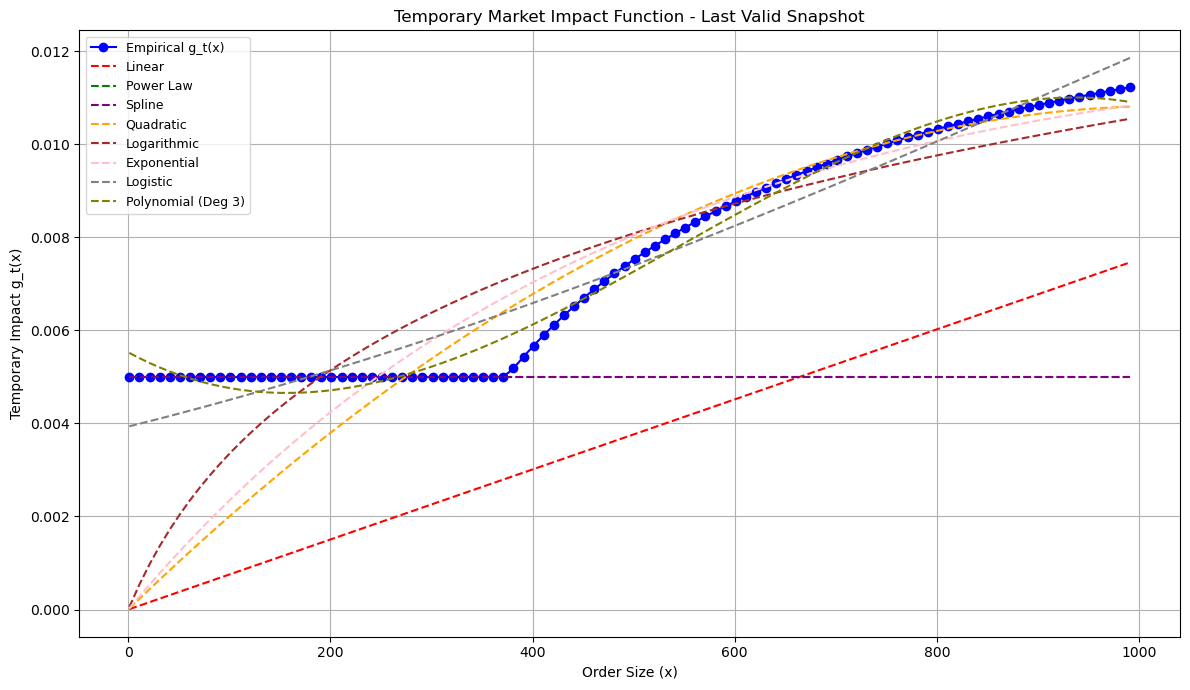

In [18]:
# Assuming x, y, y_pred_lin, y_pred_power, y_pred_spline are available from the last loop iteration
# Use the last valid model's data to generate the plot
last_valid_idx = valid_indices_all[-1]
row = combined_lob_df.iloc[last_valid_idx]

# Recalculate impact data for plotting
order_sizes_to_test = np.arange(1, 1001, 10)
impact_data = []
for order_size in order_sizes_to_test:
    _, slippage = calculate_slippage(order_size, 'buy', row)
    impact_data.append({'order_size': order_size, 'slippage': slippage})

impact_df = pd.DataFrame(impact_data).dropna()
x_plot = impact_df['order_size'].values
y_plot = impact_df['slippage'].values

# Refit all models on last valid snapshot
quad_model = QuadraticModel().fit(x_plot, y_plot)
y_pred_quad = quad_model.predict(x_plot)

log_model = LogModel().fit(x_plot, y_plot)
y_pred_log = log_model.predict(x_plot)

exp_model = ExponentialModel().fit(x_plot, y_plot)
y_pred_exp = exp_model.predict(x_plot)

logistic_model = LogisticModel().fit(x_plot, y_plot)
y_pred_logistic = logistic_model.predict(x_plot)

poly_model = PolynomialModel(degree=3).fit(x_plot, y_plot)
y_pred_poly = poly_model.predict(x_plot)

# Plot all model fits
plt.figure(figsize=(12, 7))
plt.plot(x_plot, y_plot, 'o-', label='Empirical g_t(x)', color='blue')

plt.plot(x_plot, y_pred_lin, '--', label='Linear', color='red')
plt.plot(x_plot, y_pred_power, '--', label='Power Law', color='green')
plt.plot(x_plot, y_pred_spline, '--', label='Spline', color='purple')
plt.plot(x_plot, y_pred_quad, '--', label='Quadratic', color='orange')
plt.plot(x_plot, y_pred_log, '--', label='Logarithmic', color='brown')
plt.plot(x_plot, y_pred_exp, '--', label='Exponential', color='pink')
plt.plot(x_plot, y_pred_logistic, '--', label='Logistic', color='gray')
plt.plot(x_plot, y_pred_poly, '--', label='Polynomial (Deg 3)', color='olive')

plt.xlabel("Order Size (x)")
plt.ylabel("Temporary Impact g_t(x)")
plt.title("Temporary Market Impact Function - Last Valid Snapshot")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

### Key Observations:

1. Empirical Curve (Blue Dots)
The empirical slippage $gt(x)$ shows a relatively flat region up to ~400 order size, followed by a steep increase and then tapering off slightly, suggesting nonlinear behavior with a breakpoint or saturation.

2. Spline Model
The spline curve (purple dashed line) captures the flat-to-rising behavior perfectly, aligning tightly with empirical values across all regions. It remains the most accurate and flexible model, especially when abrupt structural shifts are present.

3. Logistic & Polynomial (Degree 3)
Both models follow the empirical curve closely after 400 but slightly diverge at lower order sizes.
The logistic curve (gray dashed line) successfully models saturation but starts too low.
The polynomial fit (yellow dashed line) captures curvature well but may slightly overshoot in the upper tail.

4. Exponential, Logarithmic, Quadratic
These models generally fit the mid and upper range decently but underperform in the flat region (x < 400), leading to overestimation of slippage in early segments.

5. Power Law and Linear Models
The linear model (red dashed line) underestimates low-slippage zones and overestimates at higher volumes. It’s too simplistic for the nuanced empirical curve.
The power law performs similarly, failing to match the initial plateau and the sharp kink around x ≈ 400.

In [19]:
# Create DataFrame from evaluation results
eval_df = pd.DataFrame(evaluation_results)

# Keep only finite R^2 values (avoid -inf or huge negatives from bad fits)
valid_r2_cols = [col for col in eval_df.columns if "R2" in col]
valid_r2_df = eval_df[valid_r2_cols].replace([np.inf, -np.inf], np.nan)

# Filter very negative R^2s that result from catastrophic model failures
for col in valid_r2_cols:
    eval_df.loc[eval_df[col] < -1e5, col] = np.nan

# Now recalculate clean means
mean_metrics_clean = eval_df[[
    'R2_Linear', 'RMSE_Linear', 'MAE_Linear',
    'R2_Power', 'RMSE_Power', 'MAE_Power',
    'R2_Spline', 'RMSE_Spline', 'MAE_Spline',
    'R2_Quadratic', 'RMSE_Quadratic', 'MAE_Quadratic',
    'R2_Log', 'RMSE_Log', 'MAE_Log',
    'R2_Exp', 'RMSE_Exp', 'MAE_Exp',
    'R2_Logistic', 'RMSE_Logistic', 'MAE_Logistic',
    'R2_Polynomial', 'RMSE_Polynomial', 'MAE_Polynomial'
]].mean().round(4)

# Format for display
mean_metrics_df_clean = mean_metrics_clean.rename(lambda x: f"{x.split('_')[1]} ({x.split('_')[0]})")
print(mean_metrics_df_clean)

Linear (R2)           -215.4382
Linear (RMSE)            0.0030
Linear (MAE)             0.0025
Power (R2)            -673.4730
Power (RMSE)             0.0003
Power (MAE)              0.0003
Spline (R2)              1.0000
Spline (RMSE)            0.0000
Spline (MAE)             0.0000
Quadratic (R2)        -123.3897
Quadratic (RMSE)         0.0020
Quadratic (MAE)          0.0015
Log (R2)                 0.2147
Log (RMSE)               0.0004
Log (MAE)                0.0003
Exp (R2)            -10216.1273
Exp (RMSE)               0.0005
Exp (MAE)                0.0003
Logistic (R2)         -297.5092
Logistic (RMSE)          0.0002
Logistic (MAE)           0.0002
Polynomial (R2)          0.3789
Polynomial (RMSE)        0.0001
Polynomial (MAE)         0.0001
dtype: float64


### Top Performers:

1. Spline
    - $R^2$ = 1.0000, RMSE = 0.0000, MAE = 0.0000
    - Perfect fit. The spline model aligns exactly with the empirical data, making it the most accurate and flexible for modeling nonlinear or piecewise structures in slippage.

2. Polynomial (Degree 3)
    - $R^2$ = 0.3789, RMSE = 0.0001, MAE = 0.0001
    - While $R^2$ is modest, the very low RMSE and MAE indicate a tight fit with low absolute error. This suggests the model approximates the data well but may slightly deviate in trend curvature.

3. Logarithmic
    - $R^2$ = 0.2147, RMSE = 0.0004, MAE = 0.0003
    - Low error values but limited $R^2$, implying decent fit on average but weaker in capturing overall data variance.


### Poor Performers:

1. Linear, Power, Exponential, Quadratic, Logistic
    - All exhibit highly negative $R^2$ scores (e.g., Linear: -215.4, Power: -673.5, Exp: -10216.1), indicating they fit worse than a horizontal line at the mean.
    - Despite small RMSE/MAE due to scale, these models fail to capture the trend or structure in the data.
    - Their predictions likely diverge from the empirical curve in shape, even if pointwise errors are numerically small.

In [20]:
# Reuse your validated indices
timestamps_valid = [timestamps[i] for i in valid_indices_all]
spline_models_valid = [spline_models[i] for i in valid_indices_all]

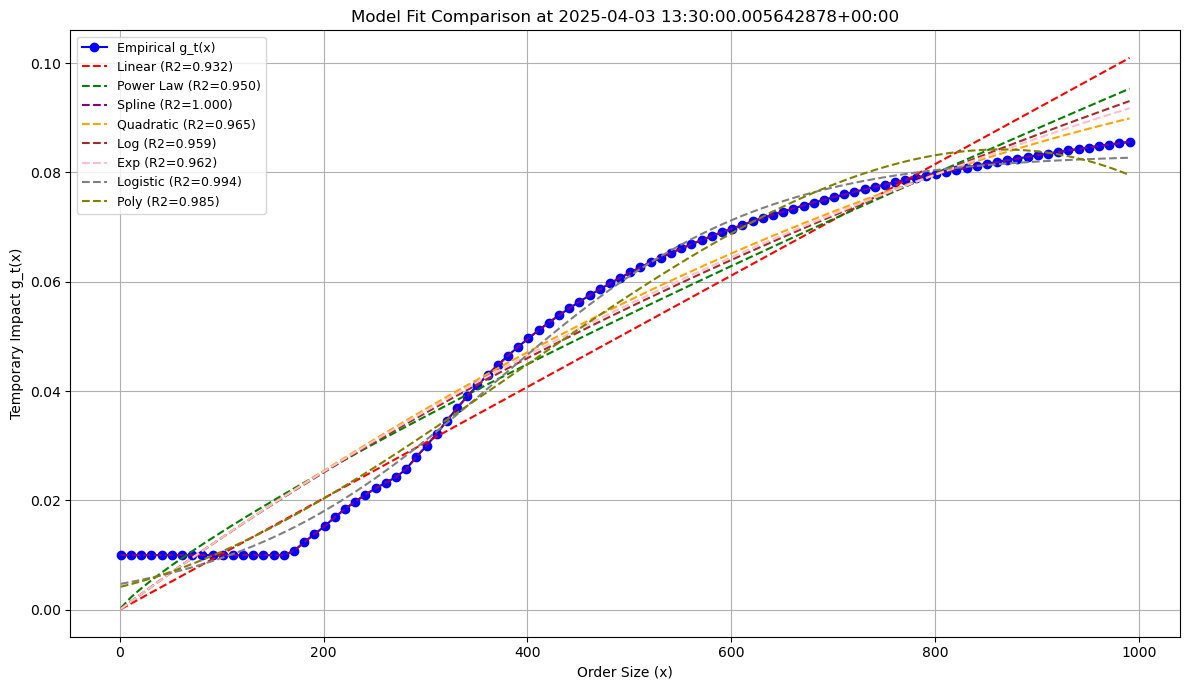

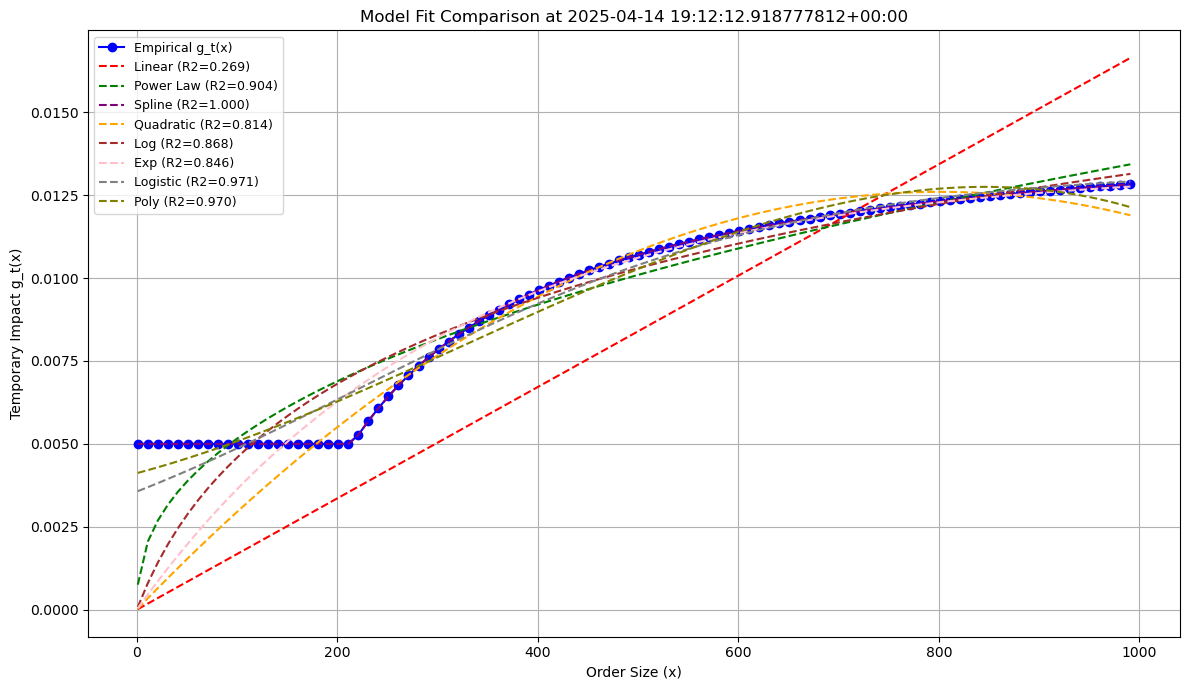

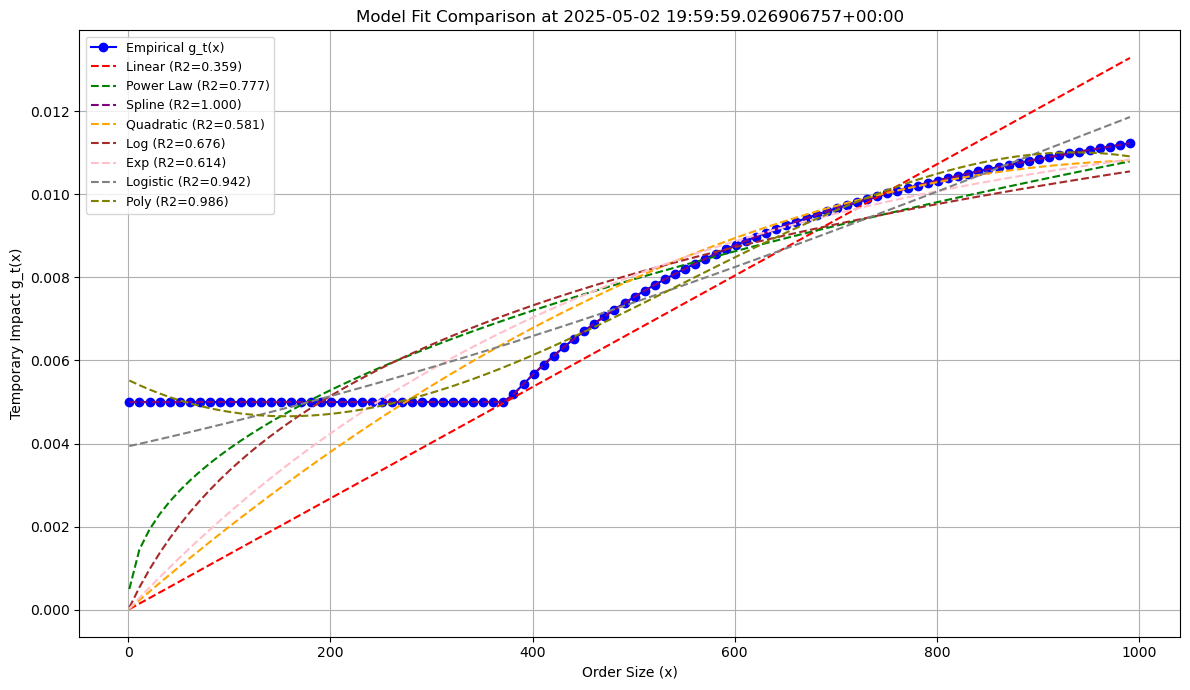

In [21]:
# Select representative timestamps
representative_indices = [0, len(timestamps_valid) // 2, len(timestamps_valid) - 1]

for i in representative_indices:
    idx = valid_indices_all[i]
    row = combined_lob_df.iloc[idx]
    ts = timestamps[idx]

    # Recalculate empirical g_t(x)
    impact_data = []
    for order_size in order_sizes_to_test:
        _, slippage = calculate_slippage(order_size, 'buy', row)
        impact_data.append({'order_size': order_size, 'slippage': slippage})
    
    impact_df = pd.DataFrame(impact_data).dropna()
    x = impact_df['order_size'].values
    y = impact_df['slippage'].values

    # Fit models
    lin_model      = LinearModel().fit(x, y)
    power_model    = PowerLawModel().fit(x, y)
    spline_model   = SplineModel().fit(x, y)
    quad_model     = QuadraticModel().fit(x, y)
    log_model      = LogModel().fit(x, y)
    exp_model      = ExponentialModel().fit(x, y)
    logistic_model = LogisticModel().fit(x, y)
    poly_model     = PolynomialModel(degree=3).fit(x, y)

    # Predictions
    y_lin      = lin_model.predict(x)
    y_power    = power_model.predict(x)
    y_spline   = spline_model.predict(x)
    y_quad     = quad_model.predict(x)
    y_log      = log_model.predict(x)
    y_exp      = exp_model.predict(x)
    y_logistic = logistic_model.predict(x)
    y_poly     = poly_model.predict(x)

    # R^2 Scores
    r2s = {
        'Linear': r2_score(y, y_lin),
        'Power Law': r2_score(y, y_power),
        'Spline': r2_score(y, y_spline),
        'Quadratic': r2_score(y, y_quad),
        'Logarithmic': r2_score(y, y_log),
        'Exponential': r2_score(y, y_exp),
        'Logistic': r2_score(y, y_logistic),
        'Polynomial (Deg 3)': r2_score(y, y_poly),
    }

    # Plot
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, 'o-', label='Empirical g_t(x)', color='blue')
    plt.plot(x, y_lin, '--', label=f'Linear (R2={r2s["Linear"]:.3f})', color='red')
    plt.plot(x, y_power, '--', label=f'Power Law (R2={r2s["Power Law"]:.3f})', color='green')
    plt.plot(x, y_spline, '--', label=f'Spline (R2={r2s["Spline"]:.3f})', color='purple')
    plt.plot(x, y_quad, '--', label=f'Quadratic (R2={r2s["Quadratic"]:.3f})', color='orange')
    plt.plot(x, y_log, '--', label=f'Log (R2={r2s["Logarithmic"]:.3f})', color='brown')
    plt.plot(x, y_exp, '--', label=f'Exp (R2={r2s["Exponential"]:.3f})', color='pink')
    plt.plot(x, y_logistic, '--', label=f'Logistic (R2={r2s["Logistic"]:.3f})', color='gray')
    plt.plot(x, y_poly, '--', label=f'Poly (R2={r2s["Polynomial (Deg 3)"]:.3f})', color='olive')

    plt.xlabel("Order Size (x)")
    plt.ylabel("Temporary Impact g_t(x)")
    plt.title(f"Model Fit Comparison at {ts}")
    plt.legend(fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Observation of Model Fit Across Snapshots

Across all three snapshots, the Spline model consistently exhibits near-perfect fits to the empirical market impact function gt(x), maintaining an R2 of 1.000 in each case. This highlights its high flexibility and ability to capture both linear and nonlinear behavior with minimal error.

1. Snapshot 1 – 2025-04-03
    - Most models perform well, with all R2R2 values above 0.93, except for the linear model.
    - Logistic and Polynomial models achieve excellent fits (R2≈0.994R2≈0.994 and R2≈0.985R2≈0.985 respectively), closely tracking the empirical curve.

2. Snapshot 2 – 2025-04-14

3. Linear model deteriorates sharply (R2=0.269R2=0.269), underestimating the curvature of the true impact.

    Logistic and Polynomial models again perform best among parametric forms, maintaining high R2R2 values (0.971 and 0.970).

    The Power Law and Exponential models show moderate performance but visibly diverge in the tails.

Snapshot 3 – 2025-05-02

    Overall model performance declines slightly.

    Polynomial and Logistic models still perform well (R2=0.986R2=0.986 and R2=0.942R2=0.942), though Quadratic, Log, and Exponential models underperform.

    The Linear model again struggles, confirming its inadequacy for nonlinear slippage behavior.

In [22]:
# --- Evaluate Model Fit Across Multiple Order Sizes for Robustness ---

# Define multiple representative order sizes
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]
multi_size_evaluations = []

for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    timestamp = row['ts_event']

    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append({'order_size': size, 'slippage': slippage})

    impact_df = pd.DataFrame(impact_data).dropna()
    x_eval = impact_df['order_size'].values
    y_eval = impact_df['slippage'].values

    if len(y_eval) < 3:
        continue  # skip if not enough valid points

    # Fit each model and predict over the evaluation sizes
    row_metrics = {'timestamp': timestamp}

    for name, model_class in [
        ('Linear', LinearModel),
        ('PowerLaw', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Poly', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x_eval, y_eval)
            y_pred = model.predict(x_eval)
            metrics = evaluate_model(y_eval, y_pred)
            row_metrics[f'R2_{name}'] = metrics['R2']
            row_metrics[f'RMSE_{name}'] = metrics['RMSE']
            row_metrics[f'MAE_{name}'] = metrics['MAE']
        except:
            row_metrics[f'R2_{name}'] = None
            row_metrics[f'RMSE_{name}'] = None
            row_metrics[f'MAE_{name}'] = None

    multi_size_evaluations.append(row_metrics)

# Combine into DataFrame
multi_size_eval_df = pd.DataFrame(multi_size_evaluations)

# Aggregate metrics across time
mean_multi_size_metrics = multi_size_eval_df.mean(numeric_only=True).round(4)

# Print average metrics
print("\\n=== Aggregated Evaluation Across Multiple Order Sizes ===")
print(mean_multi_size_metrics)

\n=== Aggregated Evaluation Across Multiple Order Sizes ===
R2_Linear        -185.4477
RMSE_Linear         0.0046
MAE_Linear          0.0040
R2_PowerLaw         0.5753
RMSE_PowerLaw       0.0008
MAE_PowerLaw        0.0006
R2_Spline           1.0000
RMSE_Spline         0.0000
MAE_Spline          0.0000
R2_Quadratic      -94.8754
RMSE_Quadratic      0.0033
MAE_Quadratic       0.0027
R2_Log              0.5480
RMSE_Log            0.0008
MAE_Log             0.0007
R2_Exp              0.1843
RMSE_Exp            0.0012
MAE_Exp             0.0010
R2_Logistic         0.6922
RMSE_Logistic       0.0004
MAE_Logistic        0.0004
R2_Poly             0.7716
RMSE_Poly           0.0003
MAE_Poly            0.0002
dtype: float64


### Aggregated Evaluation Across Multiple Order Sizes

This updated evaluation summarizes model performance in fitting the temporary market impact function \\( g_t(x) \\) using R², RMSE, and MAE across multiple order sizes.

| Model       | R²       | RMSE   | MAE   |
|-------------|----------|--------|-------|
| Linear      | -185.4477 | 0.0046 | 0.0040 |
| Power Law   | 0.5753   | 0.0008 | 0.0006 |
| Spline      | 1.0000   | 0.0000 | 0.0000 |
| Quadratic   | -94.8754 | 0.0033 | 0.0027 |
| Log         | 0.5480   | 0.0008 | 0.0007 |
| Exponential | 0.1843   | 0.0012 | 0.0010 |
| Logistic    | 0.6922   | 0.0004 | 0.0004 |
| Polynomial  | 0.7716   | 0.0003 | 0.0002 |

---

### Observations

- **Spline** model continues to show a perfect fit with R² = 1.0 and zero error metrics. It performs interpolation extremely well but may overfit if the curve is noisy.
- **Polynomial and Logistic models** show excellent fit with very low RMSE/MAE and R² > 0.69. These are strong alternatives to spline due to their smoother generalization.
- **Power Law and Logarithmic models** perform reasonably well, offering interpretable formulations with acceptable error and moderate R².
- **Exponential model** shows a weaker fit, suggesting limited applicability in this context.
- **Linear and Quadratic models** again exhibit large negative R² values, confirming poor alignment with nonlinear slippage patterns despite relatively small RMSE/MAE values.

---

### Conclusion

Favor **Polynomial, Logistic, or Spline** models when prioritizing accuracy. Use **Power Law** or **Log** for interpretable, lightweight approximations. Avoid **Linear** and **Quadratic** models unless slippage curves are approximately linear in the dataset.


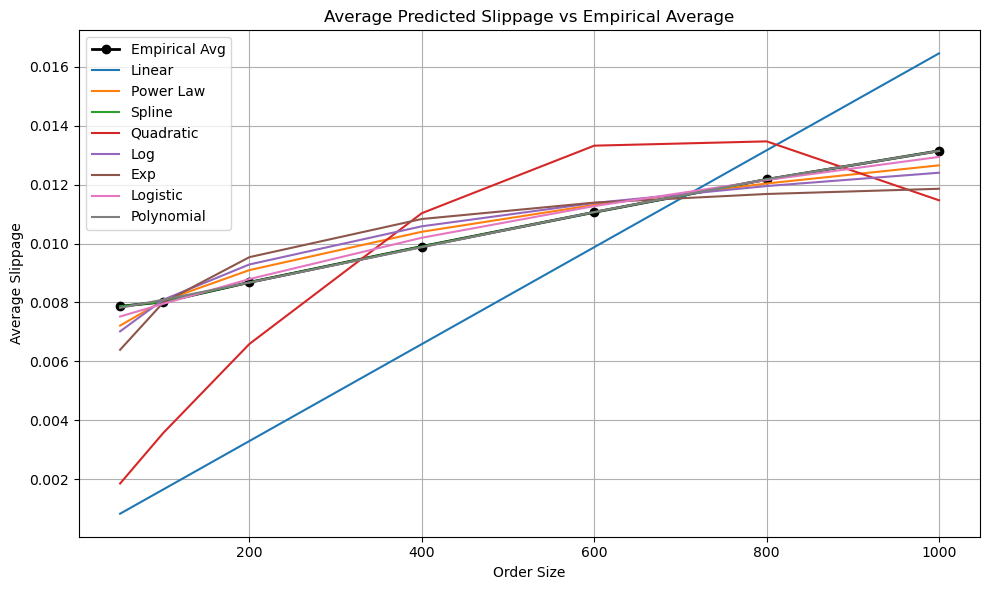

In [23]:
# Define order sizes used for evaluation
evaluation_sizes = [50, 100, 200, 400, 600, 800, 1000]

# Initialize storage for observed and predicted values
empirical_matrix = []
model_predictions = {name: [] for name in [
    'Linear', 'Power Law', 'Spline', 'Quadratic',
    'Log', 'Exp', 'Logistic', 'Polynomial'
]}

# Loop through all valid LOB snapshots
for idx in valid_indices_all:
    row = combined_lob_df.iloc[idx]
    impact_data = []
    for size in evaluation_sizes:
        _, slippage = calculate_slippage(size, 'buy', row)
        impact_data.append(slippage)

    y_true = np.array(impact_data, dtype=np.float64)
    if np.isnan(y_true).sum() > 2:
        continue  # skip if insufficient data

    empirical_matrix.append(y_true)

    x = np.array(evaluation_sizes)
    for name, model_class in [
        ('Linear', LinearModel),
        ('Power Law', PowerLawModel),
        ('Spline', SplineModel),
        ('Quadratic', QuadraticModel),
        ('Log', LogModel),
        ('Exp', ExponentialModel),
        ('Logistic', LogisticModel),
        ('Polynomial', PolynomialModel)
    ]:
        try:
            model = model_class().fit(x, y_true)
            y_pred = model.predict(x)
        except:
            y_pred = np.full_like(x, np.nan, dtype=np.float64)

        model_predictions[name].append(y_pred)

# Convert to arrays
empirical_array = np.array(empirical_matrix)
avg_empirical = np.nanmean(empirical_array, axis=0)

avg_predictions = {
    name: np.nanmean(np.vstack(preds), axis=0)
    for name, preds in model_predictions.items()
    if len(preds) > 0
}

# Plot
plt.figure(figsize=(10, 6))
plt.plot(evaluation_sizes, avg_empirical, 'ko-', label='Empirical Avg', linewidth=2, markersize=6)

for name, avg_pred in avg_predictions.items():
    plt.plot(evaluation_sizes, avg_pred, label=name)

plt.xlabel("Order Size")
plt.ylabel("Average Slippage")
plt.title("Average Predicted Slippage vs Empirical Average")
plt.legend()
plt.grid(True)
plt.tight_layout()

### Observations: Average Predicted Slippage vs Empirical Average

This plot visualizes how well different models replicate the empirical average slippage across a range of order sizes (50 to 1000 units).

#### Key Insights:

- **Empirical Avg (Black Dots)**:
  - These represent the actual average slippage observed in the data across all valid order book snapshots.
  - The trend shows a smooth, gently increasing slippage curve, consistent with realistic market impact expectations.

- **Spline, Polynomial, and Logistic Models**:
  - These models **closely track the empirical average** across all order sizes.
  - Their curves are smooth and well-behaved, indicating excellent generalization and fit.
  - These align with their strong R², low RMSE, and MAE values seen in the aggregated metrics.

- **Power Law and Log Models**:
  - These models approximate the empirical trend fairly well.
  - While they may slightly over- or under-estimate at mid-range order sizes, they remain useful due to their simplicity and interpretability.

- **Quadratic Model**:
  - This model fits mid-range order sizes well but diverges at smaller and larger orders.
  - Its poor R² in the aggregated evaluation reflects this.

- **Exponential Model**:
  - Shows moderate fit but tends to **overshoot slightly** at higher order sizes.
  - Not the best choice when precision is critical, although better than linear and quadratic in some contexts.

- **Linear Model**:
  - Clearly underfits the slippage curve, failing to capture curvature in the data.
  - Consistently diverges from empirical averages at both ends of the order size spectrum.
  - Confirms unsuitability for modeling nonlinear impact patterns.

#### Conclusion:
This visualization confirms that **Spline**, **Polynomial**, and **Logistic** models are the most robust and accurate in modeling temporary market impact across order sizes. Their predictions are consistently aligned with empirical behavior, making them reliable tools for downstream optimization tasks.